**<h2>Plant Pathology using PyTorch's Transfer Learning Framework</h2>**

1. Importing helping hands 
2. Reading the files
3. Analysis of the data
4. Looking at some samples
5. Split the data in train and validation split
6. Preparing Imagedataset and transformations
7. Training and validation function
8. Fixing the hyperparameters for the model training
9. Resnet18 pretrained from torchvision.models
10. Crosentropyloss and Adam optimizer
11. Ploting the training and validation accuracy

In [1]:
import time
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import OrderedDict


import cv2
import torch
from torch import optim
import torchvision
import torch.nn as nn
import torch.utils.data as Data
from torchvision import models,transforms
import time

#changes
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
root = "/kaggle/input/plant-pathology-2020-fgvc7/"
train = pd.read_csv(os.path.join(root,"train.csv"))
test = pd.read_csv(os.path.join(root,"test.csv"))
submission = pd.read_csv(os.path.join(root,"sample_submission.csv"))
images = os.path.join(root,"images")

**<h2>Data Analysis</h2>**

* we have 1821 images for the training and testing each. 
* plants are divided in four categories => [ healthy | multiple_diseases | rust | scab ] 
* there are few plant samples with multiple_diseases

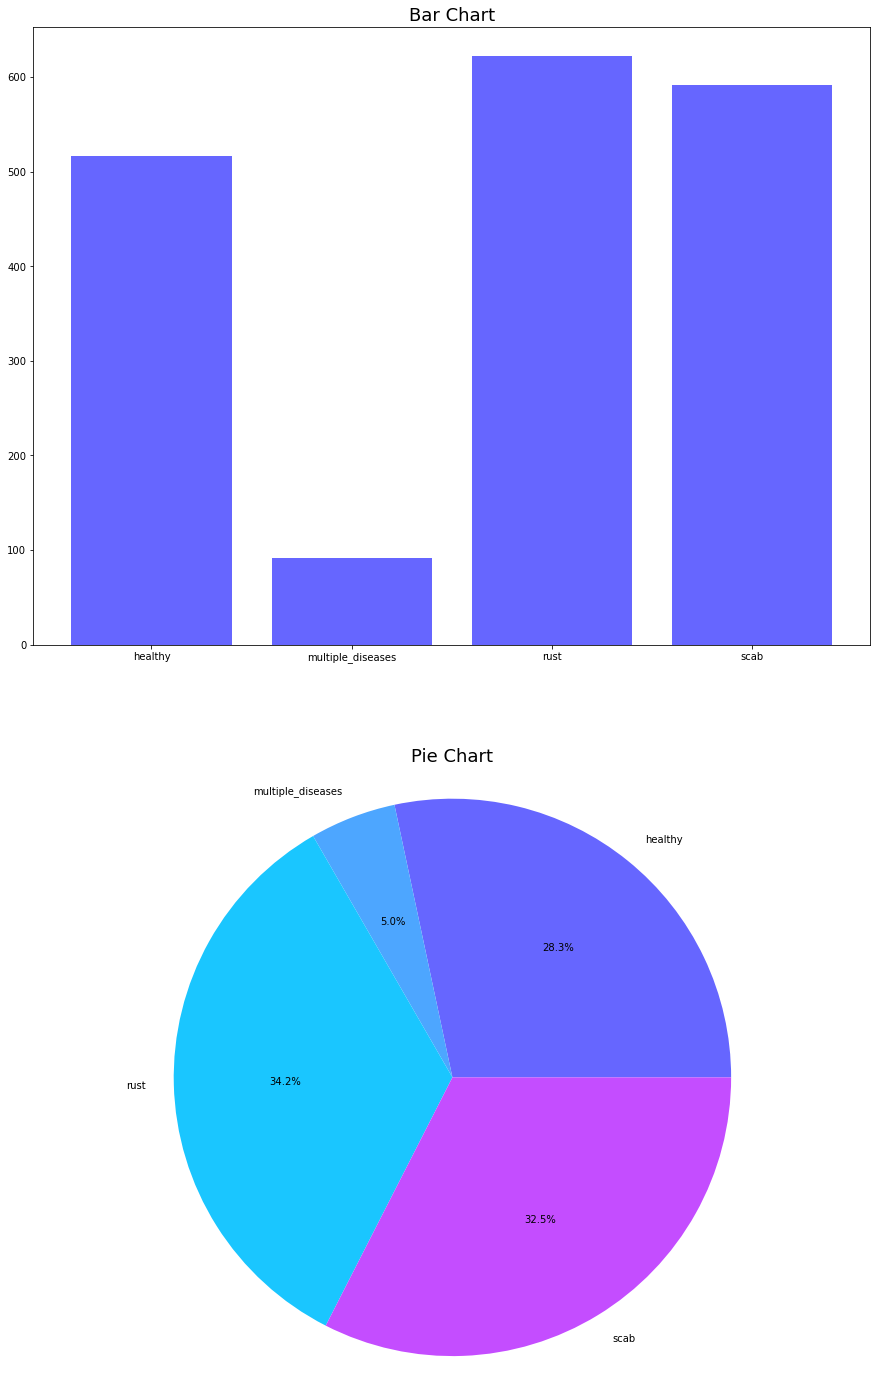

In [3]:
diseases = dict()

for column in ["healthy","multiple_diseases","rust","scab"]:
    counts = pd.DataFrame(train[column].value_counts())
    diseases[column] = counts.iloc[1,0]
    
#bar chart to show different diseases    
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,25))
ax1.bar(diseases.keys(),diseases.values(), color=["#6666ff"])
ax1.set_title('Bar Chart', fontsize=18)

ax2.pie(diseases.values(),labels = diseases.keys(), colors=["#6666ff","#4da6ff","#1ac6ff","#c44dff"], autopct='%1.1f%%')
ax2.set_title('Pie Chart', fontsize=18)
ax2.axis('equal') 

plt.show()


**<h2>Let's look at the images</h2>**
here we have 4 images from each classes.

**<span style="font-size:18px">Rust</span>**

There are more than 5,000 known species of rust on plants. Common rust (Phragmidium spp.) is a fungal disease that attacks roses, hollyhocks, snapdragons, daylilies, beans, tomatoes and lawns. It is most often found on mature plants where symptoms appear primarily on the surfaces of lower leaves.Early on, look for white, slightly raised spots on the undersides of leaves and on the stems. After a short period of time, these spots become covered with reddish-orange spore masses. Later, leaf postules may turn yellow-green and eventually black. Severe infestations will deform and yellow leaves and cause leaf drop.
(acknowledgement: www.planetnatural.com)

**<span style="font-size:18px">Scab</span>**

A serious disease of apples and ornamental crabapples, apple scab (Venturia inaequalis) attacks both leaves and fruit. The fungal disease forms pale yellow or olive-green spots on the upper surface of leaves. Dark, velvety spots may appear on the lower surface. Severely infected leaves become twisted and puckered and may drop early in the summer.
acknowledgement: www.planetnatural.com)

Row's are in order of ['healthy', 'multiple_diseases', 'rust', 'scab']


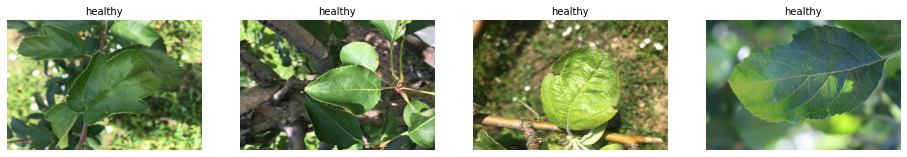

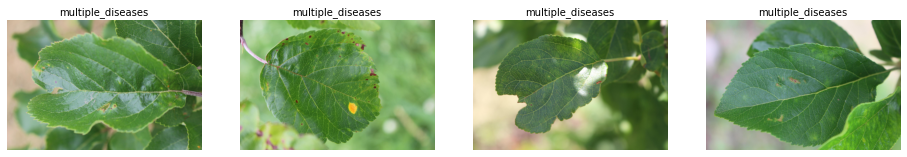

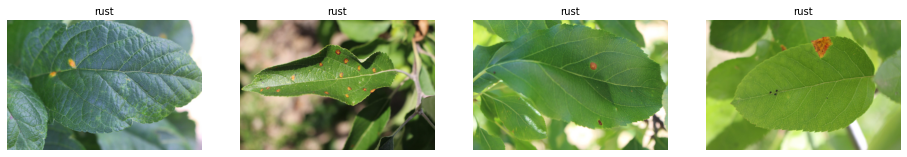

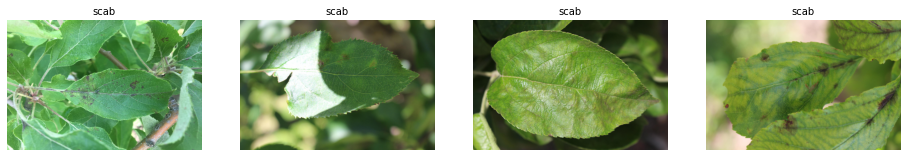

In [4]:
def ShowImages(images, typ):
    fig = figure(figsize=(16,12))
    number_of_images = len(images)
    for i in range(number_of_images):
        a=fig.add_subplot(1,number_of_images,i+1)
        a.set_title(typ, fontsize = 10)
        image = imread(os.path.join(root,"images",images[i]))
        imshow(image)
        axis('off')
        
col=["healthy","multiple_diseases","rust","scab"]
print("Row's are in order of", col)

for column in col:
    images = (train[train[column].apply(lambda x: x == 1)]["image_id"].sample(4).values) + ".jpg"
    ShowImages(images, column)

**<h2>Train and Validation Split</h2>**

In [5]:
def get_path(image):
    return os.path.join(root,"images",image + ".jpg")

train_data = train.copy()
train_data["image_path"] = train_data["image_id"].apply(get_path)
train_labels = train.loc[:, "healthy":"scab"]

test_data = test.copy()
test_data["image_path"] = test_data["image_id"].apply(get_path)
test_paths = test_data["image_path"]

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_data["image_path"], train_labels, test_size = 0.2, random_state=23, stratify = train_labels)

train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

**<h2>Datapreparation & Transformation function</h2>**

In [6]:
mytransform = {
    "train": A.Compose([
    A.RandomResizedCrop(height=256, width=256, p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
    ]),
    "validation": A.Compose([
    A.RandomResizedCrop(height=256, width=256, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
    ]),
}


class ImageDataset(Data.Dataset):
    def __init__(self, images_path, labels = None , test=False, transform=None):
        self.images_path = images_path
        self.test = test
        if self.test == False:
            self.labels = labels
            
        self.images_transform = transform

    def __getitem__(self, index):
        if self.test == False:
            labels = torch.tensor(np.argmax(self.labels.iloc[index, :]))
        
        image = cv2.imread(self.images_path[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_transformed = self.images_transform(image=image)
        
        if self.test ==False:
            return image_transformed["image"], labels
        return image_transformed["image"]

    def __len__(self):
        return self.images_path.shape[0]

**<h2>Training and validation function</h2>**

In [7]:
def train_function(model, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    progress = tqdm(loader, desc="Training")
    
    for _, (images,labels) in enumerate(progress):
        
        images, labels = images.to(device), labels.to(device)
        model.train()
        
        #optimizer
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()*labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc,labels.cpu().detach().numpy()), axis=0)
        preds_for_acc = np.concatenate((preds_for_acc,np.argmax(predictions.cpu().detach().numpy(), axis=1)), axis=0)


    accuracy = accuracy_score(labels_for_acc, preds_for_acc)

    return running_loss/TRAIN_SIZE, accuracy


In [8]:
def valid_function(model, loader):
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    progress = tqdm(loader, desc="Validation")
    
    for _, (images,labels) in enumerate(progress):
        
        images, labels = images.to(device), labels.to(device)
        
        
        with torch.no_grad():
            model.eval()
            predictions = model(images)
        loss = loss_function(predictions, labels)

        running_loss += loss.item()*labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc,labels.cpu().detach().numpy()), axis=0)
        preds_for_acc = np.concatenate((preds_for_acc,np.argmax(predictions.cpu().detach().numpy(), axis=1)), axis=0)


    accuracy = accuracy_score(labels_for_acc, preds_for_acc)
    conf_matrix = confusion_matrix(labels_for_acc, preds_for_acc)

    return running_loss/VALID_SIZE, accuracy, conf_matrix

In [23]:
BATCH_SIZE = 64 #4
NUM_EPOCHS = 15 #10
device = "cuda"
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]
learning_rate = 5e-5

In [24]:
train_images = ImageDataset(images_path=train_paths, labels=train_labels, transform=mytransform["train"])
train_loader = Data.DataLoader(train_images, shuffle=True, batch_size = BATCH_SIZE)

valid_images = ImageDataset(images_path=valid_paths, labels=valid_labels, transform=mytransform["validation"])
valid_loader = Data.DataLoader(valid_images, shuffle=False, batch_size = BATCH_SIZE)

**<h2>Resnet18, CrossEntropyLoss, Adam</h2>**

In [25]:
model = models.resnet50(pretrained = True)

# Freeze training for all layers
for param in model.parameters():
    param.require_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs,512,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.3),
                          nn.Linear(512,4, bias = True))

model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [26]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

In [27]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = train_function(model, loader = train_loader)
    vl, va, conf_mat = valid_function(model, loader = valid_loader)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)

Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.9835312484384893, Val loss: 0.48956707577182823, Train acc: 0.6462912087912088, Val acc: 0.873972602739726


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.4441599277677117, Val loss: 0.3238789916038513, Train acc: 0.8736263736263736, Val acc: 0.8876712328767123


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.307746281008144, Val loss: 0.2878604151614725, Train acc: 0.8997252747252747, Val acc: 0.9123287671232877


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.2812840502995711, Val loss: 0.3052185351717962, Train acc: 0.9038461538461539, Val acc: 0.8876712328767123


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.26418172461645945, Val loss: 0.25450969873225854, Train acc: 0.9127747252747253, Val acc: 0.9068493150684932


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.22918986930296972, Val loss: 0.28064460133853025, Train acc: 0.9271978021978022, Val acc: 0.8958904109589041


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.24533859664922233, Val loss: 0.23791856755540797, Train acc: 0.9141483516483516, Val acc: 0.9287671232876712


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.21572133767735827, Val loss: 0.23873808053258347, Train acc: 0.9292582417582418, Val acc: 0.9287671232876712


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.1735516355915384, Val loss: 0.189853961908654, Train acc: 0.9429945054945055, Val acc: 0.936986301369863


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.18583867395972156, Val loss: 0.23143066412782015, Train acc: 0.9306318681318682, Val acc: 0.9342465753424658


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.1808142894571954, Val loss: 0.2329946720845079, Train acc: 0.9375, Val acc: 0.9205479452054794


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.17647352945673597, Val loss: 0.2071769696392425, Train acc: 0.9416208791208791, Val acc: 0.9315068493150684


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.15119095146656036, Val loss: 0.20118155806031945, Train acc: 0.948489010989011, Val acc: 0.9424657534246575


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.1553523601083965, Val loss: 0.23137660455213835, Train acc: 0.9478021978021978, Val acc: 0.9424657534246575


Validation: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]

Epoch: 14, Train loss: 0.12730900255533364, Val loss: 0.21816901389050158, Train acc: 0.9553571428571429, Val acc: 0.9260273972602739


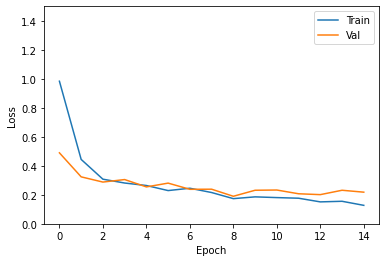

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

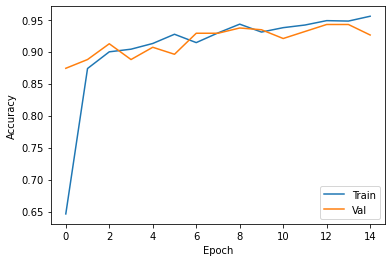

In [29]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

**<h2>Submission</h2>**

In [30]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

def test_function(model, loader):
    preds_for_output = np.zeros((1,4))
    
    progress = tqdm(loader, desc="Testing")
    with torch.no_grad():
        for _, images in enumerate(progress):
            images = images.to(device)
            model.eval()
            predictions = model(images)
            preds_for_output = np.concatenate((preds_for_output, sigmoid(predictions.cpu().detach().numpy())), axis=0)
        preds_for_output = np.delete(preds_for_output, 0, 0)
    return preds_for_output

In [31]:
test_images = ImageDataset(images_path=test_paths, test=True, transform=mytransform["validation"])
test_loader = Data.DataLoader(test_images, shuffle=False, batch_size = BATCH_SIZE)

predictions = test_function(model, test_loader)

submission[["healthy","multiple_diseases","rust","scab"]]  = predictions
submission.to_csv("submission_2.csv", index=False)

Testing: 100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


**<h2>My Learning</h2>**

1. I found that Albumentation gives better results than the torchvision.transforms.
2. I had to use different combinations of hyperperameters to understand the behaviour of the model.
3. Having a smaller batchsize and Adam as a optimizer shows drastic result improvement compare to bigger batchsize and SGD as a optimization technique.
4. There are so many things one can try here, It's just a simple framework.

I encourage you to fork on this notebook and apply different ideas on transfer learning.
